# Example: Sleep Stage Classifier Evaluation using Accel & Heart Rate

This notebook demonstrates the evaluation of a classifier for detecting sleep stages: Wakefulness, REM (Rapid Eye Movement), and NREM (Non-Rapid Eye Movement).
- We'll generate synthetic data based on accelerometer and heart rate features.
- We'll then create a simple classifier, and evaluate its performance using confusion matrix, precision, recall, and F1 score.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Set random seed for reproducibility
np.random.seed(42)

## Synthetic Data Generation

We'll create synthetic data to simulate accelerometer, heart rate, and heart rate variability (HRV) measurements for different sleep stages. This function generates data with the following characteristics:

- Wakefulness: Higher accelerometer activity, higher heart rate, lower HRV
- REM: Low accelerometer activity, slightly elevated heart rate, moderate HRV
- NREM: Very low accelerometer activity, lower heart rate, higher HRV

We then extract a bunch of features from the accelerometer and heart rate signals (e.g. min, max, mean, etc); we also extract some specialized features from heart rate corresponding to heart rate variability (e.g. rmssd, sdnn); and obtain the dominant frequency using the `welch` function from SciPy.

In [2]:
def generate_synthetic_data(n_samples=1000, window_size=30):
    # Generate base signals
    time = np.arange(n_samples * window_size) / 100  # Assuming 100 Hz sampling rate
    accel_x = np.random.randn(n_samples * window_size)
    accel_y = np.random.randn(n_samples * window_size)
    accel_z = np.random.randn(n_samples * window_size)
    heart_rate = np.random.normal(60, 10, n_samples * window_size)
    
    # Generate labels
    labels = np.random.choice(['Wakefulness', 'REM', 'NREM'], n_samples, p=[0.5, 0.3, 0.2])
    labels = np.repeat(labels, window_size)
    
    # Adjust signals based on sleep stage (with more overlap and noise)
    for i, label in enumerate(labels):
        if label == 'Wakefulness':
            accel_x[i] += np.random.normal(0, 1.2)
            accel_y[i] += np.random.normal(0, 1.2)
            accel_z[i] += np.random.normal(0, 1.2)
            heart_rate[i] += np.random.normal(10, 5)
        elif label == 'REM':
            accel_x[i] += np.random.normal(0, 0.4)
            accel_y[i] += np.random.normal(0, 0.4)
            accel_z[i] += np.random.normal(0, 0.4)
            heart_rate[i] += np.random.normal(5, 3)
        else:  # NREM
            accel_x[i] += np.random.normal(0, 0.2)
            accel_y[i] += np.random.normal(0, 0.2)
            accel_z[i] += np.random.normal(0, 0.2)
            heart_rate[i] += np.random.normal(-5, 3)
    
    # Add random noise to all signals
    accel_x += np.random.normal(0, 1, len(accel_x))
    accel_y += np.random.normal(0, 1, len(accel_y))
    accel_z += np.random.normal(0, 1, len(accel_z))
    heart_rate += np.random.normal(0, 5, len(heart_rate))
    
    # Calculate features for each window
    features = []
    for i in range(0, len(accel_x), window_size):
        window_x = accel_x[i:i+window_size]
        window_y = accel_y[i:i+window_size]
        window_z = accel_z[i:i+window_size]
        window_hr = heart_rate[i:i+window_size]
        
        # Accelerometer features
        accel_magnitude = np.sqrt(window_x**2 + window_y**2 + window_z**2)
        f, Pxx = welch(accel_magnitude, fs=100, nperseg=window_size)
        dominant_freq = f[np.argmax(Pxx)]
        
        accel_features = {
            'accel_mean': np.mean(accel_magnitude),
            'accel_std': np.std(accel_magnitude),
            'accel_max': np.max(accel_magnitude),
            'accel_min': np.min(accel_magnitude),
            'accel_median': np.median(accel_magnitude),
            'accel_dominant_freq': dominant_freq
        }
        
        # Heart rate features
        hr_diff = np.diff(window_hr)
        hrv_features = {
            'hr_mean': np.mean(window_hr),
            'hr_std': np.std(window_hr),
            'hr_max': np.max(window_hr),
            'hr_min': np.min(window_hr),
            'hrv_rmssd': np.sqrt(np.mean(hr_diff**2)),
            'hrv_sdnn': np.std(window_hr),
            'hrv_pnn50': np.sum(np.abs(hr_diff) > 50) / len(hr_diff) * 100
        }
        
        features.append({**accel_features, **hrv_features, 'Stage': labels[i]})
    
    return pd.DataFrame(features)

# Generate data
data = generate_synthetic_data(2000)
data.head()

,accel_mean,accel_std,accel_max,accel_min,accel_median,accel_dominant_freq,hr_mean,hr_std,hr_max,hr_min,hrv_rmssd,hrv_sdnn,hrv_pnn50,Stage
0,3.160171,1.369994,5.736376,0.770211,3.218683,33.333333,71.754275,12.820519,103.847061,54.711142,18.543974,12.820519,0.000000,Wakefulness
1,2.757489,1.187661,5.774216,0.810158,2.668205,6.666667,70.222542,11.530130,93.633252,43.950718,14.828998,11.530130,0.000000,Wakefulness
2,2.301596,0.724049,3.705185,0.956178,2.159802,30.000000,51.979082,7.816841,71.604698,30.875331,10.537349,7.816841,0.000000,NREM
3,2.401463,0.948762,5.156052,0.565629,2.287182,6.666667,66.557528,14.364074,91.209212,36.122140,20.304962,14.364074,0.000000,REM
4,2.812697,1.054019,5.032076,0.949556,2.848692,36.666667,70.133988,12.177066,113.358585,43.797419,19.262584,12.177066,6.896552,Wakefulness


## Model Training and Evaluation

After generating and preprocessing our synthetic sleep stage data, we now move on to training our model and evaluating its performance. This section covers the following steps:

1. **Data Splitting**: We separate our features (X) and labels (y), then split them into training and testing sets.

2. **Model Training**: We use a Decision Tree classifier to train on our data.

3. **Prediction**: We use our trained model to make predictions on the test set.

4. **Visualization**: We create a heatmap to visualize the confusion matrix, providing an intuitive representation of our model's performance.

These steps allow us to assess how well our model distinguishes between Wakefulness, REM, and NREM sleep stages based on the synthetic accelerometer and heart rate data we generated.

The confusion matrix will show us:
- How many instances of each sleep stage were correctly classified (diagonal elements)
- Where misclassifications occurred (off-diagonal elements)


Confusion Matrix:
[[307  10   0]
 [  7 150   3]
 [  0   4 119]]


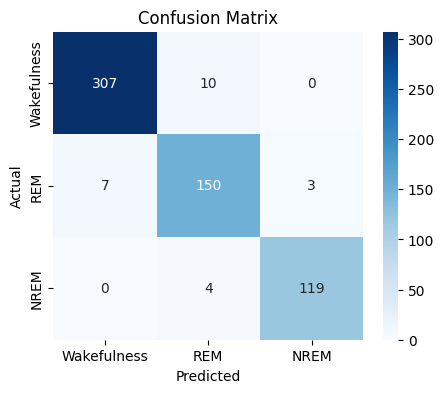

In [3]:
# Split data into features (X) and labels (y)
X = data.drop('Stage', axis=1)
y = data['Stage']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Wakefulness', 'REM', 'NREM'])

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=['Wakefulness', 'REM', 'NREM'])

# Display results
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Wakefulness', 'REM', 'NREM'],
            yticklabels=['Wakefulness', 'REM', 'NREM'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
    

## Precision, Recall and F1 score

The precision, recall, and F1 scores provide additional insights into the model's performance for each sleep stage:
- Precision: The proportion of correct positive predictions.
- Recall: The proportion of actual positive cases that were correctly identified.
- F1 Score: The harmonic mean of precision and recall, providing a balanced measure of the model's performance.

Let's proceed with the code to perform these steps and evaluate our sleep stage classifier.

In [4]:
from tabulate import tabulate

# Create a DataFrame for precision, recall, and F1 score
results_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}, index=['Wakefulness', 'REM', 'NREM'])

# Format the DataFrame as a pretty table
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt='.3f')

# Display results as a table
print("\nPrecision, Recall, and F1 Score:")
print(table)


Precision, Recall, and F1 Score:
╒═════════════╤═════════════╤══════════╤════════════╕
│             │   Precision │   Recall │   F1 Score │
╞═════════════╪═════════════╪══════════╪════════════╡
│ Wakefulness │       0.978 │    0.968 │      0.973 │
├─────────────┼─────────────┼──────────┼────────────┤
│ REM         │       0.915 │    0.938 │      0.926 │
├─────────────┼─────────────┼──────────┼────────────┤
│ NREM        │       0.975 │    0.967 │      0.971 │
╘═════════════╧═════════════╧══════════╧════════════╛


## Feature Importance Analysis

After training our Decision Tree classifier and evaluating its performance, we now turn our attention to understanding which features contribute most significantly to the model's decision-making process. This analysis is crucial for several reasons:

1. **Model Interpretability**: It helps us understand which aspects of the accelerometer and heart rate data are most influential in distinguishing between sleep stages.

2. **Feature Selection**: Identifying the most important features can guide future data collection efforts and potentially simplify the model.

We'll use the Decision Tree's built-in feature importance metric, which measures the average reduction in entropy when a particular feature is used for splitting.

The following code will:

1. Extract feature importances from the trained model.
2. Sort these importances in descending order.
3. Visualize the importances using a horizontal bar chart.
4. Print out the numerical values of feature importances.

The horizontal bar chart provides a visual representation of the relative importance of each feature, while the printed values give us precise numerical data.

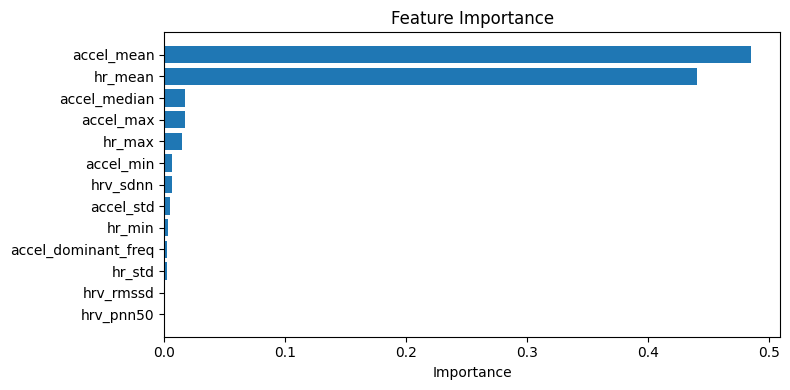


Feature Importances:
--accel_mean: 0.4849
--hr_mean: 0.4403
--accel_median: 0.0175
--accel_max: 0.0169
--hr_max: 0.0146
--accel_min: 0.0066
--hrv_sdnn: 0.0062
--accel_std: 0.0046
--hr_min: 0.0031
--accel_dominant_freq: 0.0022
--hr_std: 0.0019
--hrv_rmssd: 0.0009
--hrv_pnn50: 0.0000


In [5]:
# Feature importance
importances = clf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(importances)
sorted_importances = importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot feature importances as a horizontal bar graph
plt.figure(figsize=(8, 4))
y_pos = np.arange(len(sorted_feature_names))
plt.barh(y_pos, sorted_importances)
plt.yticks(y_pos, sorted_feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature Importances:")
for name, importance in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print("--"+f"{name}: {importance:.4f}")